# Library

In [1]:
import gc

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


import seaborn as sns
sns.set(style="whitegrid", color_codes=True)
from statsmodels.tsa.stattools import acf, pacf

from math import sqrt
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_squared_log_error as msle
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import r2_score as r2

import xgboost as xgb

pd.options.display.max_columns = 500

# Data Loading

In [2]:
data = pd.read_csv('~/Downloads/Beijing air quality/data/airquality_data.csv')

In [3]:
data.shape

(401626, 18)

# Train test split

In [4]:
data.head()

,No,year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM,station
0,1,2013,3,1,0,6.0,18.0,5.0,9.80000,800.0,88.0,0.1,1021.1,-18.6,0.0,7,4.4,5
1,2,2013,3,1,1,6.0,15.0,5.0,11.00000,800.0,88.0,-0.3,1021.5,-19.0,0.0,7,4.0,5
2,3,2013,3,1,2,5.0,18.0,5.2,10.09936,700.0,52.0,-0.7,1021.5,-19.8,0.0,14,4.6,5
3,4,2013,3,1,3,6.0,20.0,6.0,13.60000,320.0,49.8,-1.0,1022.7,-21.2,0.0,13,2.8,5
4,5,2013,3,1,4,5.0,17.0,5.0,15.60000,600.0,73.0,-1.3,1023.0,-21.4,0.0,14,3.6,5


In [5]:
train_data, test = train_test_split(data,
                               test_size=0.1,
                               shuffle=False)

In [6]:
train, valid = train_test_split(train_data,
                               test_size=0.1,
                               shuffle=False)

In [7]:
train.columns

Index(['No', 'year', 'month', 'day', 'hour', 'PM2.5', 'PM10', 'SO2', 'NO2',
       'CO', 'O3', 'TEMP', 'PRES', 'DEWP', 'RAIN', 'wd', 'WSPM', 'station'],
      dtype='object')

# Feature Engineering

## PACF

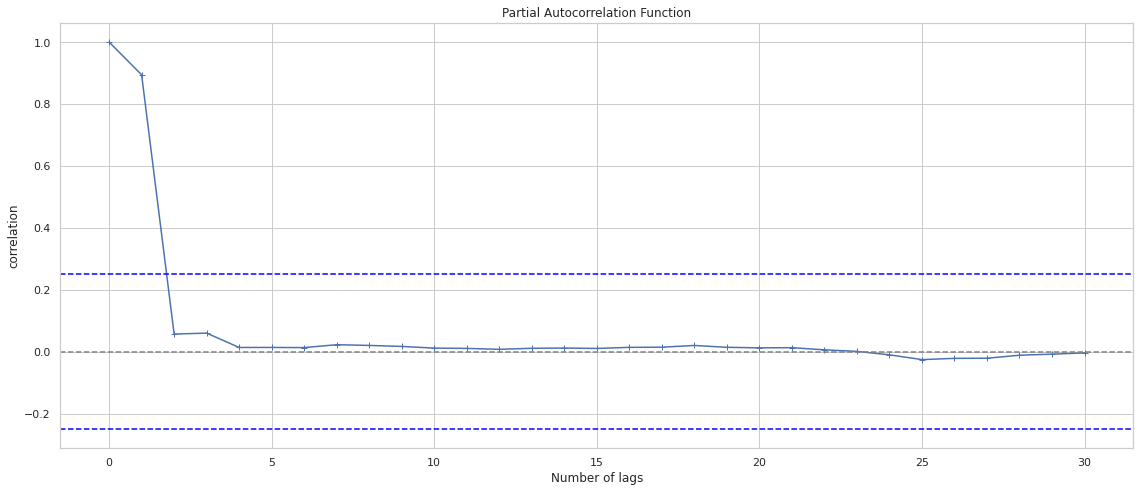

In [8]:
y = train['PM10']

#calling partial correlation function
lag_pacf = pacf(y, nlags=30, method='ols')
#Plot PACF:
plt.figure(figsize=(16, 7))
plt.plot(lag_pacf,marker='+')
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y= -((np.std(y) * 1.96)) / np.sqrt(len(y)), linestyle='--',color='blue') # lower bound
plt.axhline(y= ((np.std(y) * 1.96)) / np.sqrt(len(y)),linestyle='--',color='blue') # Upper bound
plt.title('Partial Autocorrelation Function')
plt.xlabel('Number of lags')
plt.ylabel('correlation')
plt.tight_layout()

In [9]:
def series_to_supervised(data_df, lag=2):
    
    lag_df = data_df[[col for col in data_df.columns if col not in ['No', 'year', 'month', 'day', 'hour']]].shift(lag)
    lag_df.columns = [col+"_"+f"lag_{lag}" for col in lag_df.columns]
    
    return lag_df

def rolling_window(data_df, window=1):
    
    rolling_df = data_df[[col for col in data_df.columns if col not in ['No','station', 'wd', 'year', 'month', 'day', 'hour', 'PM2.5']]].rolling(window).mean()
    rolling_df.columns = [col+"_"+f"rolling_{window}" for col in rolling_df.columns]
    
    return rolling_df

In [10]:
# Lag features by shift(1) and shift(2)
train_lag1 = series_to_supervised(train, lag=1)
train_lag2 = series_to_supervised(train, lag=2)

# Rolling window by 2
train_rolling2 = rolling_window(train, window=2)

# Concat everything together
train = pd.concat([train, train_lag1, train_lag2, train_rolling2], axis=1).dropna()

# Cumulative wind speed
train['cum_wspm'] = train['WSPM'].cumsum()

# Saturated vapor pressure
train['saturated_vapor_pressure'] = 6.11*10*((7.5*train['TEMP'])/(237.3+train['TEMP']))
# Actual vapor pressure
train['actual_vapor_pressure'] = 6.11*10*((7.5*train['DEWP'])/(237.3+train['DEWP']))

# Lag features by shift(1) and shift(2)
valid_lag1 = series_to_supervised(valid, lag=1)
valid_lag2 = series_to_supervised(valid, lag=2)

# Rolling window by 2
valid_rolling2 = rolling_window(valid, window=2)

# Concat everything together
valid = pd.concat([valid, valid_lag1, valid_lag2, valid_rolling2], axis=1).dropna()

# Cumulative wind speed
valid['cum_wspm'] = valid['WSPM'].cumsum()

# Saturated vapor pressure
valid['saturated_vapor_pressure'] = 6.11 * 10 * ((7.5 * valid['TEMP']) / (237.3 + valid['TEMP']))
# Actual vapor pressure
valid['actual_vapor_pressure'] = 6.11 * 10 * ((7.5 * valid['DEWP']) / (237.3 + valid['DEWP']))


# Lag features by shift(1) and shift(2)
test_lag1 = series_to_supervised(test, lag=1)
test_lag2 = series_to_supervised(test, lag=2)

# Rolling window by 2
test_rolling2 = rolling_window(test, window=2)

# Concat everything together
test = pd.concat([test, test_lag1, test_lag2, test_rolling2], axis=1).dropna()

# Cumulative wind speed
test['cum_wspm'] = test['WSPM'].cumsum()

# Saturated vapor pressure
test['saturated_vapor_pressure'] = 6.11 * 10 * ((7.5 * test['TEMP']) / (237.3 + test['TEMP']))
# Actual vapor pressure
test['actual_vapor_pressure'] = 6.11 * 10 * ((7.5 * test['DEWP']) / (237.3 + test['DEWP']))

# endogenous variables
features_columns = [col for col in train.columns if col not in ['No', 'PM2.5']]

del train_lag1, train_lag2, train_rolling2
del valid_lag1, valid_lag2, valid_rolling2
del test_lag1, test_lag2, test_rolling2

_ = gc.collect()

In [11]:
d_train = xgb.DMatrix(train[features_columns], train["PM2.5"])
d_val = xgb.DMatrix(valid[features_columns], valid["PM2.5"])
d_test = xgb.DMatrix(test[features_columns].astype("float"))

# Fit and train xgboost
XGB_PARAMS = {'objective': 'reg:gamma',
              'eval_metric': ["rmsle", "mae", "rmse"],
              'boosting_type': 'gbdt',
              'learning_rate': 0.01,
              'colsample_bytree': 0.5,
              'subsample': 0.9,
              'max_depth': 6,
              'min_child_weight': 200,
              'tree_method': 'gpu_hist', 'gpu_id': 0,
              'seed':42
             }

model = xgb.train(XGB_PARAMS, d_train, evals=[(d_val, "val")], num_boost_round=15000, verbose_eval=50,
                          early_stopping_rounds=150)

# Predictions and score on validation data
pred_val = model.predict(d_val)
pred_test = model.predict(d_test)

mse_score_valid = mse(y_true=valid["PM2.5"], y_pred=pred_val)
mae_score_valid = mae(y_true=valid["PM2.5"], y_pred=pred_val)
msle_score_valid = msle(y_true=valid["PM2.5"], y_pred=pred_val)
r2_score_valid = r2(y_true=valid["PM2.5"], y_pred=pred_val)

mse_score_test = mse(y_true=test["PM2.5"], y_pred=pred_test)
mae_score_test = mae(y_true=test["PM2.5"], y_pred=pred_test)
msle_score_test = msle(y_true=test["PM2.5"], y_pred=pred_test)
r2_score_test = r2(y_true=test["PM2.5"], y_pred=pred_test)
print("\n")

print(f"Xgboost rmse valid: {sqrt(mse_score_valid)}")
print(f"Xgboost mae valid: {mae_score_valid}")
print(f"Xgboost rmsle valid: {sqrt(msle_score_valid)}")
print(f"Xgboost r2 valid{r2_score_valid}")

print('\n')

print(f"Xgboost rmse test: {sqrt(mse_score_test)}")
print(f"Xgboost mae test:  {mae_score_test}")
print(f"Xgboost rmsle test: {sqrt(msle_score_test)}")
print(f"Xgboost r2 test: {r2_score_test}")

[20:17:21] WARNING: ../src/learner.cc:627: 
Parameters: { "boosting_type" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	val-rmsle:3.58438	val-mae:69.50152	val-rmse:90.57675
[50]	val-rmsle:3.39905	val-mae:69.18282	val-rmse:90.32851
[100]	val-rmsle:3.16052	val-mae:68.67150	val-rmse:89.92492
[150]	val-rmsle:2.87354	val-mae:67.86260	val-rmse:89.27396
[200]	val-rmsle:2.55009	val-mae:66.60921	val-rmse:88.23643
[250]	val-rmsle:2.20636	val-mae:64.73428	val-rmse:86.61109
[300]	val-rmsle:1.85920	val-mae:62.01709	val-rmse:84.12439
[350]	val-rmsle:1.52403	val-mae:58.23501	val-rmse:80.44251
[400]	val-rmsle:1.21436	val-mae:53.23219	val-rmse:75.23905
[450]	val-rmsle:0.94120	val-mae:47.02965	val-rmse:68.30261
[500]	val-rmsle:0.71268	val-mae:39.90893	val-rmse

[6650]	val-rmsle:0.20862	val-mae:5.88419	val-rmse:10.02315
[6700]	val-rmsle:0.20861	val-mae:5.88305	val-rmse:10.02143
[6750]	val-rmsle:0.20859	val-mae:5.88225	val-rmse:10.01966
[6800]	val-rmsle:0.20856	val-mae:5.88161	val-rmse:10.01849
[6850]	val-rmsle:0.20854	val-mae:5.88190	val-rmse:10.01806
[6900]	val-rmsle:0.20851	val-mae:5.88063	val-rmse:10.01582
[6950]	val-rmsle:0.20848	val-mae:5.87991	val-rmse:10.01383
[7000]	val-rmsle:0.20847	val-mae:5.88058	val-rmse:10.01404
[7050]	val-rmsle:0.20846	val-mae:5.88013	val-rmse:10.01298
[7100]	val-rmsle:0.20843	val-mae:5.87954	val-rmse:10.01188
[7150]	val-rmsle:0.20844	val-mae:5.88048	val-rmse:10.01218
[7200]	val-rmsle:0.20841	val-mae:5.88074	val-rmse:10.01126
[7250]	val-rmsle:0.20839	val-mae:5.88057	val-rmse:10.01048
[7300]	val-rmsle:0.20836	val-mae:5.87980	val-rmse:10.00964
[7350]	val-rmsle:0.20835	val-mae:5.87949	val-rmse:10.00888
[7400]	val-rmsle:0.20833	val-mae:5.87882	val-rmse:10.00754
[7450]	val-rmsle:0.20830	val-mae:5.87809	val-rmse:10.006

# Configuration

In [12]:
N_SPLITS = 5
SEED = 42

In [13]:
train_data.shape[0] // (N_SPLITS + 1)

60243

In [14]:
np.ceil(train_data.shape[0]*0.1).astype(int)

36147

# XGBOOST CV

In [15]:
oof_xgb = np.zeros((train_data.shape[0]))
oof_target = np.zeros((train_data.shape[0]))

predictions_xgb = np.zeros((test.shape[0]))
counter = 1


mse_scores_xgb = []
mae_scores_xgb = []
msle_scores_xgb = []
r2_scores_xgb = []

# Lag features by shift(1) and shift(2)
train_lag1 = series_to_supervised(train_data, lag=1)
train_lag2 = series_to_supervised(train_data, lag=2)

# Rolling window by 2
train_rolling2 = rolling_window(train_data, window=2)

# Concat everything together
train_data = pd.concat([train_data, train_lag1, train_lag2, train_rolling2], axis=1).dropna()

# Cumulative wind speed
train_data['cum_wspm'] = train_data['WSPM'].cumsum()

# Saturated vapor pressure
train_data['saturated_vapor_pressure'] = 6.11*10*((7.5*train_data['TEMP'])/(237.3+train_data['TEMP']))
# Actual vapor pressure
train_data['actual_vapor_pressure'] = 6.11*10*((7.5*train_data['DEWP'])/(237.3+train_data['DEWP']))


features_columns = [col for col in train_data.columns if col not in ['No', 'PM2.5']]

# TimeSeriesSplit validation 
tsp = TimeSeriesSplit(n_splits=5, test_size=np.ceil(train_data.shape[0]*0.1).astype(int))

for trn_idx, vld_idx in tsp.split(train_data):
    
    
    # train valid separation
    print(f"CV {counter}/{N_SPLITS}")
    print('\n')
    
    d_train = xgb.DMatrix(train_data.iloc[trn_idx][features_columns], train_data.iloc[trn_idx]["PM2.5"])
    d_val = xgb.DMatrix(train_data.iloc[vld_idx][features_columns], train_data.iloc[vld_idx]["PM2.5"])
    d_test = xgb.DMatrix(test[features_columns].astype("float"))
    
    # Fit and train xgboost
    XGB_PARAMS = {'objective': 'reg:gamma',
                  'eval_metric': ["rmsle", "mae", "rmse"],
                  'boosting_type': 'gbdt',
                  'learning_rate': 0.01,
                  'max_depth': 6,
                  "min_child_weight": 200,
                  "tree_method": 'gpu_hist', "gpu_id": 0,
                  "seed":SEED
            }
    model = xgb.train(XGB_PARAMS, d_train, evals=[(d_val, "val")], num_boost_round=15000, verbose_eval=100,
                      early_stopping_rounds=150)

    # Predictions and score on validation data
    pred_val = model.predict(d_val)
    pred_test = model.predict(d_test)
    
    mse_score_valid = mse(y_true=train_data.iloc[vld_idx]["PM2.5"], y_pred=pred_val)
    mae_score_valid = mae(y_true=train_data.iloc[vld_idx]["PM2.5"], y_pred=pred_val)
    msle_score_valid = msle(y_true=train_data.iloc[vld_idx]["PM2.5"], y_pred=pred_val)
    r2_score_valid = r2(y_true=train_data.iloc[vld_idx]["PM2.5"], y_pred=pred_val)
    print('\n')
    print(f"Fold {counter} Xgboost rmse: {sqrt(mse_score_valid)}")
    print(f"Fold {counter} Xgboost  mae: {mae_score_valid}")
    print(f"Fold {counter} Xgboost rmsle: {sqrt(msle_score_valid)}")
    print(f"Fold {counter} Xgboost r2: {r2_score_valid}")
    print('\n')
    mse_scores_xgb.append(sqrt(mse_score_valid))
    mae_scores_xgb.append(mae_score_valid)
    msle_scores_xgb.append(sqrt(msle_score_valid))
    r2_scores_xgb.append(r2_score_valid)
    oof_xgb[vld_idx] = pred_val
    predictions_xgb += pred_test / N_SPLITS
    counter += 1
    

    
# Inference score
mse_score_test = mse(y_true=test["PM2.5"], y_pred=predictions_xgb)
mae_score_test = mae(y_true=test["PM2.5"], y_pred=predictions_xgb)
msle_score_test = msle(y_true=test["PM2.5"], y_pred=predictions_xgb)
r2_score_test = r2(y_true=test["PM2.5"], y_pred=predictions_xgb)

print(f"Xgboost rmse cv: {np.array(mse_scores_xgb).mean()}")
print(f"Xgboost rmae cv: {np.array(mae_scores_xgb).mean()}")
print(f"Xgboost rmsle cv: {np.array(msle_scores_xgb).mean()}")
print(f"Xgboost r2 cv: {np.array(r2_scores_xgb).mean()}")

print('\n')

print(f"Xgboost rmse test: {sqrt(mse_score_test)}")
print(f"Xgboost rmae test: {mae_score_test}")
print(f"Xgboost rmsle test: {sqrt(msle_score_test)}")
print(f"Xgboost r2 test: {r2_score_test}")

CV 1/5


[01:32:53] WARNING: ../src/learner.cc:627: 
Parameters: { "boosting_type" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	val-rmsle:3.57547	val-mae:69.54455	val-rmse:91.07934
[100]	val-rmsle:3.15392	val-mae:68.72215	val-rmse:90.43056
[200]	val-rmsle:2.54704	val-mae:66.69790	val-rmse:88.74766
[300]	val-rmsle:1.85740	val-mae:62.15964	val-rmse:84.63185
[400]	val-rmsle:1.20695	val-mae:53.35987	val-rmse:75.66241
[500]	val-rmsle:0.68705	val-mae:39.68809	val-rmse:59.70613
[600]	val-rmsle:0.34281	val-mae:24.20722	val-rmse:38.91747
[700]	val-rmsle:0.16073	val-mae:12.18819	val-rmse:20.63651
[800]	val-rmsle:0.08785	val-mae:5.66764	val-rmse:9.74343
[900]	val-rmsle:0.06700	val-mae:2.98320	val-rmse:5.07139
[1000]	val-rmsle:0.06134	val-mae:2.06936	va

[7700]	val-rmsle:0.04374	val-mae:0.82591	val-rmse:1.67190
[7800]	val-rmsle:0.04373	val-mae:0.82552	val-rmse:1.67146
[7900]	val-rmsle:0.04369	val-mae:0.82504	val-rmse:1.67206
[7920]	val-rmsle:0.04369	val-mae:0.82497	val-rmse:1.67182


Fold 2 Xgboost rmse: 1.6718016731571266
Fold 2 Xgboost  mae: 0.8249404732661975
Fold 2 Xgboost rmsle: 0.04369025550394192
Fold 2 Xgboost r2: 0.9991422432153859


CV 3/5


[01:34:13] WARNING: ../src/learner.cc:627: 
Parameters: { "boosting_type" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	val-rmsle:3.35918	val-mae:57.56518	val-rmse:79.09464
[100]	val-rmsle:2.94530	val-mae:56.75510	val-rmse:78.47889
[200]	val-rmsle:2.35620	val-mae:54.80763	val-rmse:76.89490
[300]	val-rmsle:1.69727	val-mae:50.60089	val-rmse:73.076

[3000]	val-rmsle:0.04574	val-mae:0.93132	val-rmse:1.94415
[3100]	val-rmsle:0.04553	val-mae:0.91898	val-rmse:1.92414
[3200]	val-rmsle:0.04535	val-mae:0.90859	val-rmse:1.90657
[3300]	val-rmsle:0.04521	val-mae:0.90091	val-rmse:1.89427
[3400]	val-rmsle:0.04508	val-mae:0.89279	val-rmse:1.88119
[3500]	val-rmsle:0.04495	val-mae:0.88516	val-rmse:1.86640
[3600]	val-rmsle:0.04486	val-mae:0.88038	val-rmse:1.85655
[3700]	val-rmsle:0.04476	val-mae:0.87692	val-rmse:1.84796
[3800]	val-rmsle:0.04465	val-mae:0.87261	val-rmse:1.83929
[3900]	val-rmsle:0.04455	val-mae:0.86771	val-rmse:1.83021
[4000]	val-rmsle:0.04445	val-mae:0.86357	val-rmse:1.82242
[4100]	val-rmsle:0.04434	val-mae:0.85950	val-rmse:1.81355
[4200]	val-rmsle:0.04423	val-mae:0.85574	val-rmse:1.80650
[4300]	val-rmsle:0.04416	val-mae:0.85359	val-rmse:1.80315
[4400]	val-rmsle:0.04408	val-mae:0.85220	val-rmse:1.80020
[4500]	val-rmsle:0.04400	val-mae:0.84938	val-rmse:1.79399
[4600]	val-rmsle:0.04391	val-mae:0.84857	val-rmse:1.79089
[4700]	val-rms

[10700]	val-rmsle:0.03259	val-mae:0.75510	val-rmse:1.56124
[10800]	val-rmsle:0.03255	val-mae:0.75462	val-rmse:1.56030
[10900]	val-rmsle:0.03249	val-mae:0.75363	val-rmse:1.55875
[11000]	val-rmsle:0.03246	val-mae:0.75313	val-rmse:1.55786
[11100]	val-rmsle:0.03242	val-mae:0.75243	val-rmse:1.55588
[11200]	val-rmsle:0.03239	val-mae:0.75219	val-rmse:1.55561
[11300]	val-rmsle:0.03235	val-mae:0.75199	val-rmse:1.55530
[11400]	val-rmsle:0.03231	val-mae:0.75192	val-rmse:1.55444
[11500]	val-rmsle:0.03227	val-mae:0.75128	val-rmse:1.55358
[11600]	val-rmsle:0.03225	val-mae:0.75068	val-rmse:1.55350
[11700]	val-rmsle:0.03222	val-mae:0.75018	val-rmse:1.55281
[11800]	val-rmsle:0.03218	val-mae:0.74913	val-rmse:1.55147
[11900]	val-rmsle:0.03215	val-mae:0.74850	val-rmse:1.55032
[12000]	val-rmsle:0.03212	val-mae:0.74824	val-rmse:1.55030
[12100]	val-rmsle:0.03208	val-mae:0.74790	val-rmse:1.55002
[12200]	val-rmsle:0.03204	val-mae:0.74758	val-rmse:1.54963
[12300]	val-rmsle:0.03202	val-mae:0.74733	val-rmse:1.549

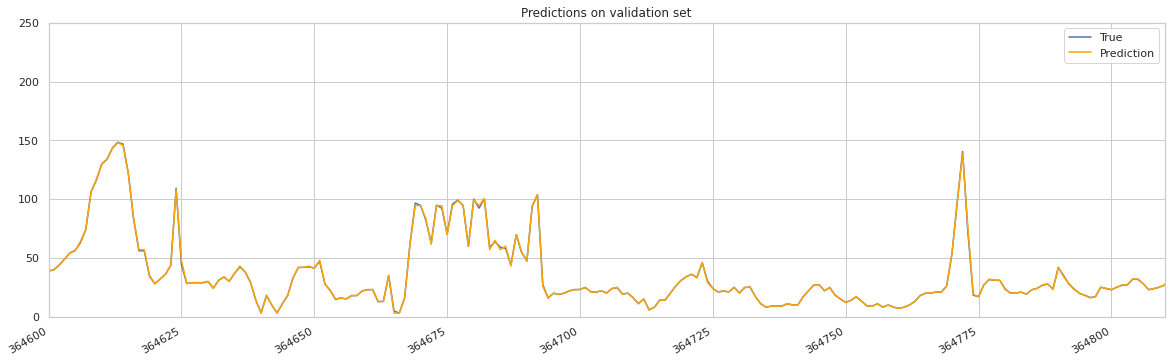

In [16]:
fig, ax = plt.subplots(figsize=(20, 6))
ax.plot(test["PM2.5"].index, predictions_xgb, color='b', label='True')
ax.plot(test["PM2.5"].index, test["PM2.5"], color='orange', label='Prediction')

ax.set_title("PM2.5", fontweight="bold", size=16)
ax.legend(loc="upper right")


## Rotate date labels automatically
ax.axis([364600, 364810, 0, 250])
fig.autofmt_xdate()
plt.title('Predictions on validation set')
plt.show()